In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
from scipy.linalg import block_diag
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
### SET UP THE PRIOR ###

# number of nuisance parameters: must match number of photo-z bins
nz = 10

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7, -1.5])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3, 1.5])
prior_mean = np.array([0.3, 0.8, 0.02237, 0.674, 0.96, -1.0])
prior_covariance = np.eye(6)*np.array([0.1, 0.1, 0.00015, 0.005, 0.3, 0.3])**2
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

# Prior over eta (nuisances)
eta_lower = np.ones(nz)*-0.1
eta_upper = np.ones(nz)*0.1
eta_mean = np.zeros(nz)
eta_covariance = np.eye(nz)*0.05**2
eta_prior = priors.TruncatedGaussian(eta_mean, eta_covariance, eta_lower, eta_upper)

# Joint prior over nuisances and interesting parameters
joint_lower = np.concatenate([lower, eta_lower])
joint_upper = np.concatenate([upper, eta_upper])
joint_mean = np.concatenate([prior_mean, eta_mean])
joint_covariance = block_diag(prior_covariance, eta_covariance)
joint_prior = priors.TruncatedGaussian(joint_mean, 
                                       joint_covariance,
                                       joint_lower,
                                       joint_upper)

In [3]:
### SET UP THE SIMULATOR ###

# import tomographic n(z)
pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb'))

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShearPhotozDE(pz = pz, lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args, batch):
    
    return CosmicShearSimulator.simulate(theta, seed)
simulator_args = None

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.02237, 0.674, 0.96, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(theta_fiducial)
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
step = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
dCdt = CosmicShearSimulator.compute_derivatives(theta_fiducial, step)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(theta_fiducial, nl, Cinv, dCdt, prior_mean=joint_mean, prior_covariance=joint_covariance)

Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [5]:
### LOAD IN THE DATA VECTOR ###
#data = compressor(simulator(theta_fiducial, 0, simulator_args), compressor_args)
data = compressor(C, compressor_args)

In [ ]:
# Create the neural density estimator (MDN)
MDN = ndes.MixtureDensityNetwork(n_inputs=16, n_outputs=16, n_components=3, n_hidden=[80,80], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
DelfiMDN = delfi.Delfi(data, joint_prior, MDN, Finv, theta_fiducial, 
                       param_limits = [joint_lower, joint_upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b h^2', 'h', 'n_s', 'w_0', 'b1', 'b2', 'b3', 'b4',
                                     'b5','b6','b7','b8','b9','b10'], 
                       results_dir = "simulators/cosmic_shear/results_darkenergy_nuisances/mdn")

Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


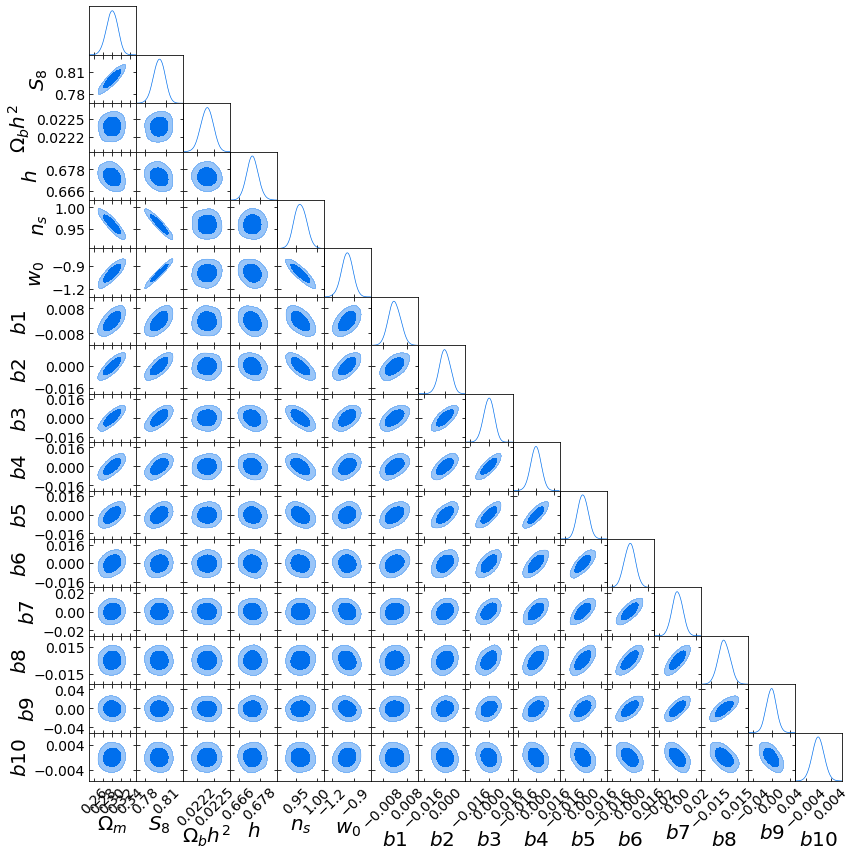

In [ ]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining()

/Users/justinalsing/Dropbox/science/delfi/master/delfi/simulators/cosmic_shear/cosmic_shear.py:928: RuntimeWarning: invalid value encountered in log
  logpkz = np.log(cosmo.pk(np.exp(logk), z2a(z)))


Simulator returns exception for parameter values: [ 2.28352495e-01  7.65346930e-01  2.22857851e-02  6.76164713e-01
  1.01861860e+00 -1.38876743e+00 -2.83757424e-02 -2.82876795e-02
 -1.82227114e-02 -1.09828808e-02 -1.19553969e-02 -1.31073567e-02
  1.28314514e-04  1.79369915e-02  4.67222110e-02 -3.45723126e-03] (rank 0)


Population 1/47
Sampling proposal density...
Done.


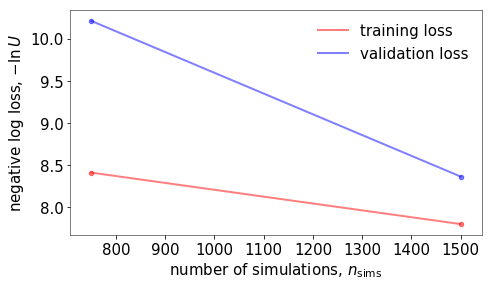

Population 2/47
Sampling proposal density...
Done.


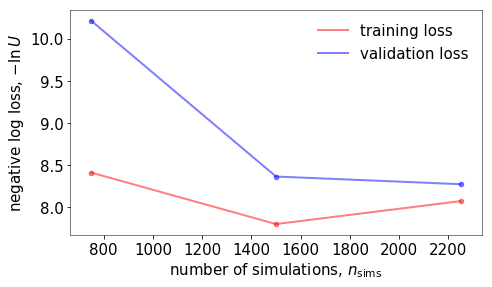

Population 3/47
Sampling proposal density...
Done.


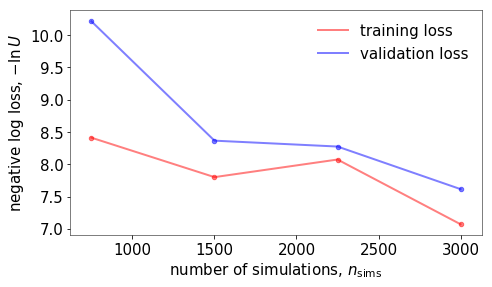

Population 4/47
Sampling proposal density...
Done.


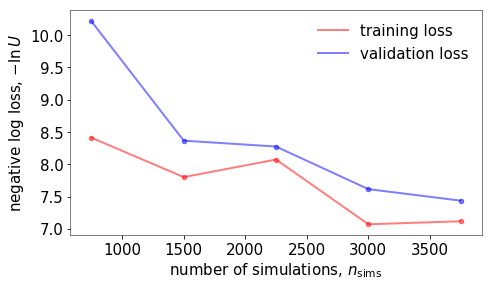

Population 5/47
Sampling proposal density...
Done.


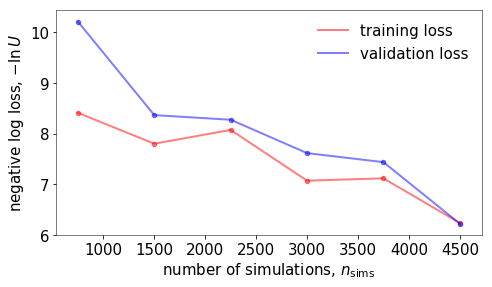

Population 6/47
Sampling proposal density...
Done.


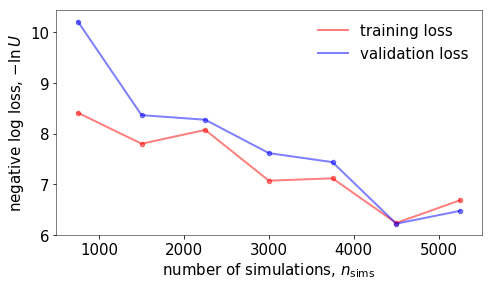

Population 7/47
Sampling proposal density...
Done.


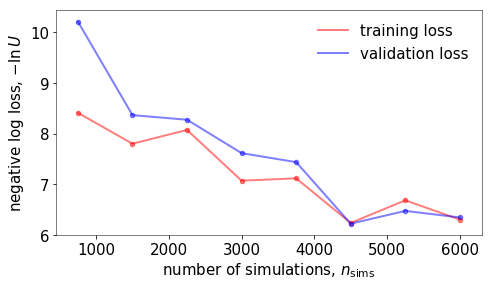

Population 8/47
Sampling proposal density...
Done.


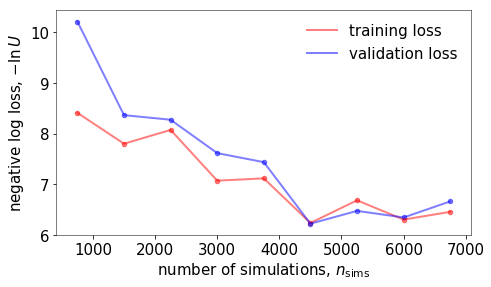

Population 9/47
Sampling proposal density...
Done.


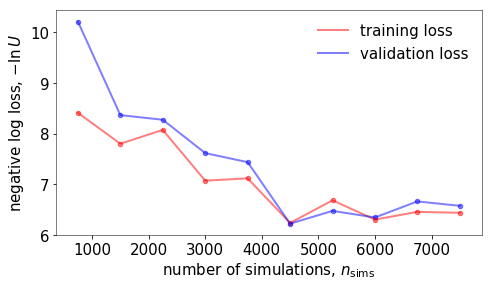

Population 10/47
Sampling proposal density...
Done.


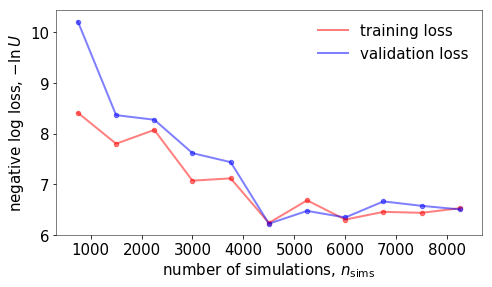

Population 11/47
Sampling proposal density...
Done.


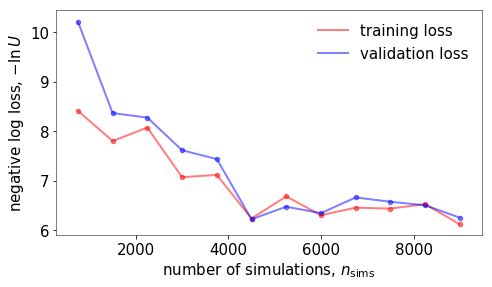

Population 12/47
Sampling proposal density...
Done.


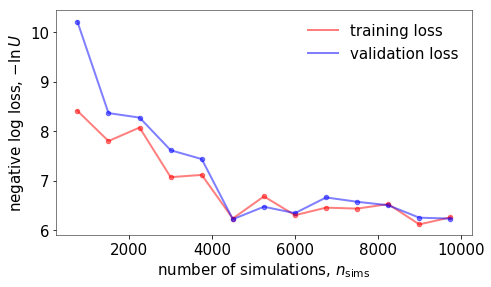

Population 13/47
Sampling proposal density...
Done.


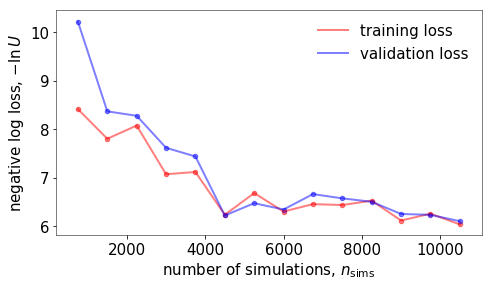

Population 14/47
Sampling proposal density...
Done.


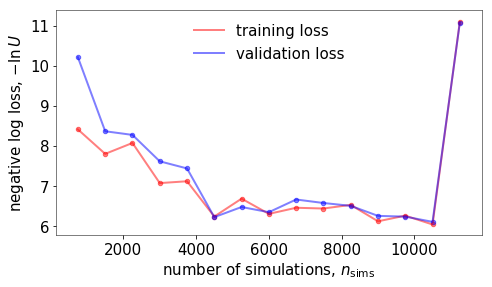

Population 15/47
Sampling proposal density...
Done.


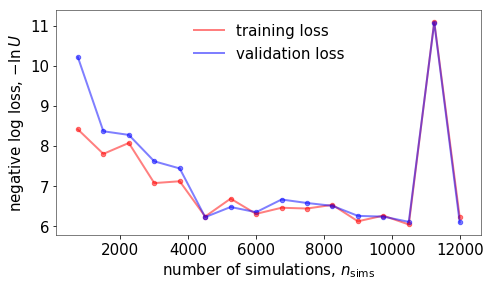

Population 16/47
Sampling proposal density...
Done.


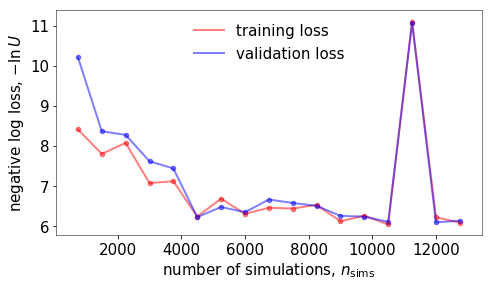

Population 17/47
Sampling proposal density...
Done.


Simulator returns exception for parameter values: [ 3.01533420e-01  8.01352364e-01  2.25071159e-02  6.74589498e-01
  9.61325769e-01 -1.01979591e+00  5.90594292e-03 -6.01854638e-04
  1.00319488e-03  9.56262367e-03  5.92578705e-03  1.06690967e-02
  1.73166399e-02  1.29817225e-02  3.04459336e-02 -4.45381543e-04] (rank 0)


In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 750
n_batch = 750
n_populations = 47

# Do the SNL training
DelfiMDN.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, 
                             patience=10, simulator_args=simulator_args, save_intermediate_posteriors=False)

Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


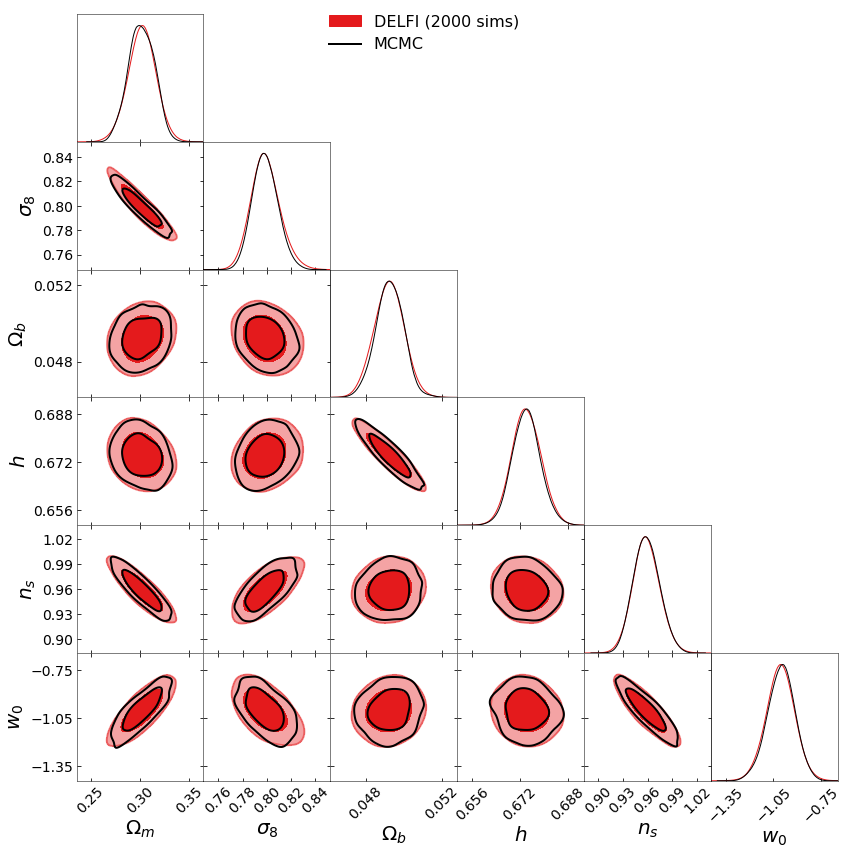

In [17]:
# Compare error ellipses with expected Fisher errors

# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)
samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])
samples_asymptotic[:,1] = samples_asymptotic[:,1]*(0.3/samples_asymptotic[:,0])**0.5
samples_asymptotic[:,2] = samples_asymptotic[:,2]/samples_asymptotic[:,3]**2

samples_mcmc = np.concatenate([ 
                               np.loadtxt('simulators/cosmic_shear/mcmc/emcee_samples_systematics_de1.dat')[:,0:6], 
                               np.loadtxt('simulators/cosmic_shear/mcmc/emcee_samples_systematics_de2.dat')[:,0:6],
                               np.loadtxt('simulators/cosmic_shear/mcmc/emcee_samples_systematics_de3.dat')[:,0:6],
                               np.loadtxt('simulators/cosmic_shear/mcmc/emcee_samples_systematics_de4.dat')[:,0:6]])

samples_mcmc[:,1] = samples_mcmc[:,1]*(0.3/samples_mcmc[:,0])**0.5
samples_mcmc[:,2] = samples_mcmc[:,2]/samples_mcmc[:,3]**2

samples_delfi = np.loadtxt('simulators/cosmic_shear/results_darkenergy_marginal/mdnposterior_samples_10.dat')
samples_delfi[:,1] = samples_delfi[:,1]*(0.3/samples_delfi[:,0])**0.5
samples_delfi[:,2] = samples_delfi[:,2]/samples_delfi[:,3]**2
new_names = DelfiMDN.names
new_names[1] = '\sigma_8'
new_names[2] = '\Omega_b'

samples = [samples_delfi, samples_mcmc]#, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = DelfiMDN.names, labels = DelfiMDN.labels, ranges = DelfiMDN.ranges) for s in samples]

# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2

#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False,False], normalized=[True,True,True], legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1, 1], contour_ls = ['-','-', '-.'], contour_colors=['#E41A1C','black', 'blue'])
g.add_legend(legend_labels=['DELFI (2000 sims)', 'MCMC', 'fisher matrix'], figure=True)

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('../../paper_II/plots/cosmic_shear_contours_marginal_mcmc.pdf')

Removed no burn in
Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


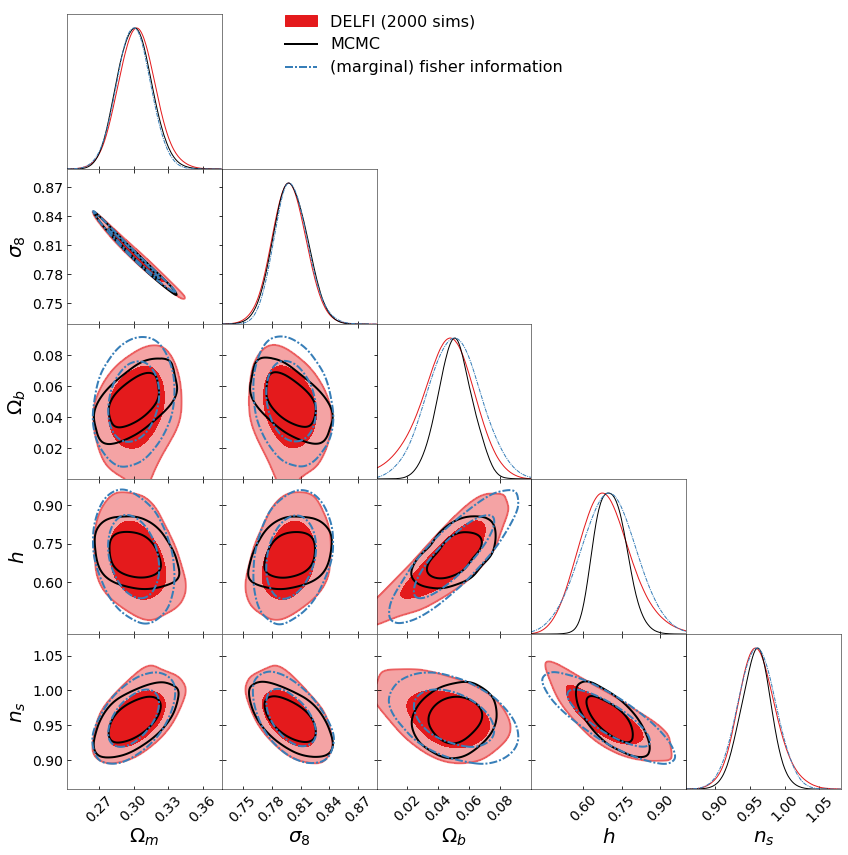

In [40]:
# Compare error ellipses with expected Fisher errors

# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)
samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])
samples_asymptotic[:,1] = samples_asymptotic[:,1]*(0.3/samples_asymptotic[:,0])**0.5

samples_mcmc = np.loadtxt('simulators/cosmic_shear/mcmc/emcee_samples_systematics1.dat')[:,0:5]
samples_mcmc[:,1] = samples_mcmc[:,1]*(0.3/samples_mcmc[:,0])**0.5

samples_delfi = np.loadtxt('simulators/cosmic_shear/results_marginal/mdnposterior_samples_47.dat')
samples_delfi[:,1] = samples_delfi[:,1]*(0.3/samples_delfi[:,0])**0.5
new_names = DelfiMDN.names
new_names[1] = '\sigma_8'

samples = [samples_delfi, samples_mcmc, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = DelfiMDN.names, labels = DelfiMDN.labels, ranges = DelfiMDN.ranges) for s in samples]

# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2

#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1, 1], contour_ls = ['-','-', '-.'], contour_colors=['#E41A1C','black', '#377EB8'])
g.add_legend(legend_labels=['DELFI (2000 sims)', 'MCMC', '(marginal) fisher information'], figure=True)

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
#plt.savefig('../../paper_II/plots/cosmic_shear_marginalized_contours_mcmc.pdf')

Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


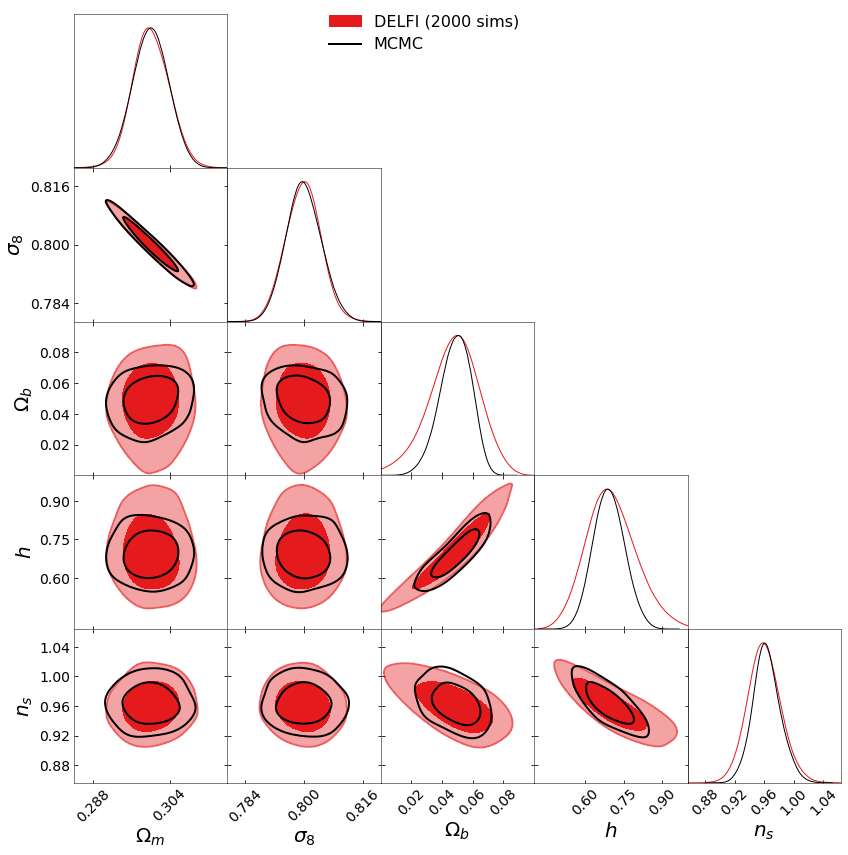

In [43]:
# Compare error ellipses with expected Fisher errors

# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)
samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])
samples_asymptotic[:,1] = samples_asymptotic[:,1]*(0.3/samples_asymptotic[:,0])**0.5

samples_mcmc = np.loadtxt('simulators/cosmic_shear/mcmc/emcee_samples1.dat')[:,0:5]
samples_mcmc[:,1] = samples_mcmc[:,1]*(0.3/samples_mcmc[:,0])**0.5

samples_delfi = np.loadtxt('simulators/cosmic_shear/results/mdnposterior_samples_24.dat')
samples_delfi[:,1] = samples_delfi[:,1]*(0.3/samples_delfi[:,0])**0.5
new_names = DelfiMDN.names
new_names[1] = '\sigma_8'

samples = [samples_delfi, samples_mcmc]
mc_samples = [MCSamples(samples=s, names = DelfiMDN.names, labels = DelfiMDN.labels, ranges = DelfiMDN.ranges) for s in samples]

# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2

#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1], contour_ls = ['-','-'], contour_colors=['#E41A1C','black'])
g.add_legend(legend_labels=['DELFI (2000 sims)', 'MCMC'], figure=True)

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('../../paper_II/plots/cosmic_shear_contours_mcmc.pdf')

In [6]:
np.savetxt('simulators/cosmic_shear/mcmc/Finv_full_de.dat', np.linalg.inv(Compressor.F))